## CNN Audio Classification based on Filter Banks for the LibriSpeech Dataset.

In [1]:
import sys
import os
sys.path.append("..") # Adds higher directory to python modules path. This is important to load the libraries  in PROJECT_HOME/src/
import src.d01_load_data as ld #Library to load data and handle data.

#speakers = ['1272', '1462', '1673', '174', '1919', '251', '422', '652', '777', '84', '2412', '2428', '2803', '3853', '6241', '8297', '5895', '3536']
speakers = ["84","174","251","422"]

#PROJECT_HOME = os.getcwd()+"/"
# NOTE that in this Jupyter notebook, the parent folder is the project home, not this!
PROJECT_HOME = os.path.dirname(os.getcwd())+"/"

SI_DATA="Speaker Identification/data/" #Speaker identification dataset.
checkpointPath = PROJECT_HOME+"Speaker Identification/checkpoints/"

dataSI = ld.DataLoader(PROJECT_HOME,SI_DATA,speakers)
filesP,filesL = dataSI.getAllFilesPath()
dTrain,lTrain, dTest, lTest = dataSI.splitTrainingTest(filesP,filesL,splitSizeTest=0.40,shuffle=True) #Shuffle before getting the Training/Test

### Reading Audio and Transform it to a Filter Bank Energy.

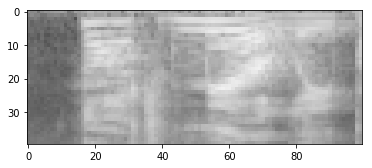

In [2]:
sAudio = ld.Audio(PROJECT_HOME+SI_DATA+"174/174-84280-0015.flac")
sAudio.read()
#Preprocessing Audio 
sFilBank = sAudio.transformToFilterBank(N=1.0,trimSilence=True,nfilters= 40)
sAudio.showSpectogramImage(sFilBank[2].T)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

class DatasetAudio(Dataset):
  def __init__(self,files,labels,categories):
    self.data=[]
    self.labels = labels #A list of the labels in numerical.
    self.categories = categories
    self.input_shape = [0,0,0] # Define the shape of the files
    self.sampleRates = []
    self.samples = []
    self.seconds = []
    nFiles = len(files)
    tmpLabels = []

    for i in tqdm(range(0, nFiles)):
        fAudio = ld.Audio(files[i])
        samp, sr = fAudio.read()
        self.samples.append(len(samp))
        self.sampleRates.append(sr)
        self.seconds.append(len(samp)/sr)
        sFilBank_list = fAudio.transformToFilterBank(N=1.0,trimSilence=True,nfilters=100)
        for sImage in sFilBank_list:
            sImage = sImage.T #Important! The image should have as first axis the filters and as second the features itself.
            self.data.append(sImage[np.newaxis,...])#Transform in 3D with a new axis.
            tmpLabels.append(self.labels[i])
    # Reassign the expanded labels
    self.labels = tmpLabels
    print(np.shape(self.data))
    print(np.shape(self.labels))
    
  def __len__(self):
    return len(self.data)
  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx]
print("Reading Training Data")
train_data = DatasetAudio(dTrain,lTrain,speakers)
print("Reading Testing Data")
valid_data = DatasetAudio(dTest,lTest,speakers)

Reading Training Data



(1288, 1, 100, 100)
(1288,)
Reading Testing Data



(733, 1, 100, 100)
(733,)


In [4]:
#Statistics of the dataset:
import pandas as pd

dfSI = pd.DataFrame(list(zip(lTrain,train_data.samples,train_data.sampleRates,train_data.seconds,dTrain)),columns=["Category","Samples Length","Sample Rate","Seconds","Path"])
dfSI.head(10)

Category  Samples Length  Sample Rate    Seconds  \
0         2           79360        16000   4.960000   
1         3          305840        16000  19.115000   
2         0          130480        16000   8.155000   
3         1           77201        16000   4.825062   
4         1          215280        16000  13.455000   
5         1          163360        16000  10.210000   
6         1           49600        16000   3.100000   
7         1          204320        16000  12.770000   
8         2          104800        16000   6.550000   
9         2          143280        16000   8.955000   

                                                Path  
0  /media/daniel/Daniel_Files/Google Drive/Master...  
1  /media/daniel/Daniel_Files/Google Drive/Master...  
2  /media/daniel/Daniel_Files/Google Drive/Master...  
3  /media/daniel/Daniel_Files/Google Drive/Master...  
4  /media/daniel/Daniel_Files/Google Drive/Master...  
5  /media/daniel/Daniel_Files/Google Drive/Master...  
6  /media/daniel/Daniel_Files/Google Drive/Master...  
7  /media/daniel/Daniel_Files/Google Drive/Master...  
8  /media/daniel/Daniel_Files/Google Drive/Master...  
9  /media/daniel/Daniel_Files/Google Drive/Master...

In [5]:
dfSI.describe()

Category  Samples Length  Sample Rate     Seconds
count  141.000000      141.000000        141.0  141.000000
mean     1.390071   140472.624113      16000.0    8.779539
std      1.060815    98069.016730          0.0    6.129314
min      0.000000    24560.000000      16000.0    1.535000
25%      0.000000    68160.000000      16000.0    4.260000
50%      1.000000   114800.000000      16000.0    7.175000
75%      2.000000   199280.000000      16000.0   12.455000
max      3.000000   522320.000000      16000.0   32.645000

In [6]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=False)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False)

Input shape

In [7]:
print(train_data.input_shape)

[0, 0, 0]


In [8]:
if torch.cuda.is_available():
    device=torch.device('cuda:0')
else:
    device=torch.device('cpu')

#If there are cuda problems, direct everything to the cpu.
#device=torch.device('cpu')
print(device)

cuda:0


## Defining Network Architecture

In [9]:
class Net(nn.Module):
    #This architecture comes from reference [2]
    def __init__(self,num_cats):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(3080, 50)
        self.fc2 = nn.Linear(50, num_cats)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        #x = x.view(-1, x.size(0))
        x = x.view(x.size(0),-1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)


num_epochs = 50
learning_rate = 0.001
momentum = 0.5
#loss_fn = nn.CrossEntropyLoss()
loss_fn = F.nll_loss

model = Net(num_cats = len(train_data.categories))
model.cuda()
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=momentum)

In [19]:
class BlockFCNConv2(nn.Module):
    #This architecture comes from reference [3]
    def __init__(self, in_c, out_c, kernel_size):
        
        super().__init__()
        self.conv = nn.Conv2d(in_channels=in_c, out_channels = out_c, kernel_size=kernel_size)
        self.batch_norm = nn.BatchNorm2d(num_features=out_c)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.conv(x)
        x = self.batch_norm(x)
        y = self.relu(x)
        return y

class FCN2(nn.Module):
    
    def __init__(self,num_cats, input_size, channels=[1, 16, 32, 16], kernels=[8, 5, 3]):
        super().__init__()
        self.conv1 = BlockFCNConv2(channels[0], channels[1], kernels[0])
        self.conv2 = BlockFCNConv2(channels[1], channels[2], kernels[1])
        self.conv3 = BlockFCNConv2(channels[2], channels[3], kernels[2])

        kernel_size = input_size - sum(kernels) + len(kernels)
        
        self.global_pooling = nn.AvgPool2d(kernel_size=kernel_size)
        self.fc1 = nn.Linear(channels[3], num_cats)
        
    def forward(self, x):

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        y = self.global_pooling(x)        
        #y = x.mean([2,3]) # you dont need to use reshape if you use this
        y = y.reshape(y.size(0),-1) # if you use average pooling, you need to flatten 
        y = self.fc1(y)
        y = F.softmax(y)

        return y
    
num_epochs = 50
learning_rate = 0.01
loss_fn = nn.CrossEntropyLoss()

model = FCN2(num_cats = len(train_data.categories), input_size = np.shape(train_data[0][0])[-1])
model.cuda()
optimizer = optim.SGD(model.parameters(), lr=learning_rate,momentum=0.5)

In [20]:
def train():
    model.train()
    batch_losses=[]
    for i, data in enumerate(train_loader):
        x, y = data
        optimizer.zero_grad()
        #x = x.to(device, dtype=torch.float32).permute(1, 0, 2)
        #y = torch.FloatTensor(y).to(device, dtype=torch.long)
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.long)
        y_hat = model(x)
        loss = loss_fn(y_hat, y)
        batch_losses.append(loss.item())
        loss.backward()
        optimizer.step()
    
    mean_loss = round( np.mean(batch_losses) , 5)#Average the losses
    print(f'Epoch - {epoch} Train-Loss : {mean_loss}')
    loss_train_epoch.append(mean_loss)

def test():
    ##Test
    model.eval()
    batch_losses_test=[]
    
    correct = 0
    stacked_labels = []
    final_test = []
    
    with torch.no_grad():
        for i, data in enumerate(valid_loader):
            x, y = data
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.long)
            y_hat = model(x)
            loss = loss_fn(y_hat, y)

            batch_losses_test.append(loss.item()) #Concatenate batch loss

            pred = y_hat.data.max(1, keepdim=True)[1]
            pred = torch.flatten(pred) # To get a one dimensional

            correct += torch.eq(y, pred).cpu().sum().numpy() #Compare and sum the predictions

            stacked_labels += y.data.cpu().numpy().tolist()
            final_test += pred.data.cpu().numpy().tolist()

        mean_loss_test = round( np.mean(batch_losses_test) , 5)
        #s = round(accuracy_score(stacked_labels, final_test)*100,2)
        conf_mat = confusion_matrix(stacked_labels, final_test)

        #valid_losses.append(batch_losses_test)

        accuracy = round((correct*100.0) / len(valid_loader.dataset),2)
        print(f'Epoch - {epoch} Valid-Loss : {mean_loss_test} Valid-Accuracy ({correct}/{len(valid_loader.dataset)}): {accuracy} %')
        loss_test_epoch.append(mean_loss_test)
        acc_test_epoch.append(accuracy)
        
        return accuracy, conf_mat   

In [21]:
torch.cuda.empty_cache()

In [22]:
loss_train_epoch = []
loss_train_epoch = []

acc_test_epoch = []
loss_test_epoch = []

batch_losses = []
train_losses = []
valid_losses = []

for epoch in tqdm(range(1,num_epochs+1)):
    train()
    accuracy,conf_mat = test()

print("Confusion Matrix:")
print(conf_mat)

Epoch - 1 Train-Loss : 1.38452
Epoch - 1 Valid-Loss : 1.35563 Valid-Accuracy (214/733): 29.2 %
Epoch - 2 Train-Loss : 1.37628
Epoch - 2 Valid-Loss : 1.34245 Valid-Accuracy (267/733): 36.43 %
Epoch - 3 Train-Loss : 1.37198
Epoch - 3 Valid-Loss : 1.33784 Valid-Accuracy (289/733): 39.43 %
Epoch - 4 Train-Loss : 1.36845
Epoch - 4 Valid-Loss : 1.33441 Valid-Accuracy (297/733): 40.52 %
Epoch - 5 Train-Loss : 1.36528
Epoch - 5 Valid-Loss : 1.33164 Valid-Accuracy (303/733): 41.34 %
Epoch - 6 Train-Loss : 1.36235
Epoch - 6 Valid-Loss : 1.32913 Valid-Accuracy (312/733): 42.56 %
Epoch - 7 Train-Loss : 1.35957
Epoch - 7 Valid-Loss : 1.32652 Valid-Accuracy (315/733): 42.97 %
Epoch - 8 Train-Loss : 1.3569
Epoch - 8 Valid-Loss : 1.32392 Valid-Accuracy (317/733): 43.25 %
Epoch - 9 Train-Loss : 1.35429
Epoch - 9 Valid-Loss : 1.32132 Valid-Accuracy (318/733): 43.38 %
Epoch - 10 Train-Loss : 1.35173
Epoch - 10 Valid-Loss : 1.31865 Valid-Accuracy (317/733): 43.25 %
Epoch - 11 Train-Loss : 1.34921
Epoch - 

In [46]:
from datetime import datetime
checkpointPath = PROJECT_HOME+"Speaker Identification/checkpoints/"
now = datetime.now()
date_time = now.strftime("%m-%d-%Y_%H-%M-%S")

checkpointFile= checkpointPath+date_time+".pt"
torch.save(model.state_dict(), checkpointFile)

##LOAD
#model = torch.load(PATH)
#model.eval()


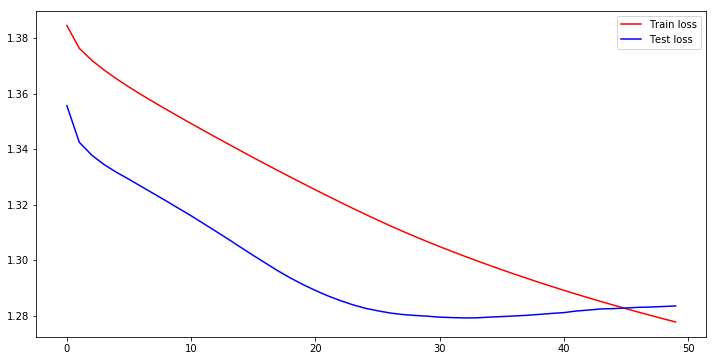

In [23]:
plt.figure(figsize=(12,6))
plt.plot(loss_train_epoch, label='Train loss',color="#ff0000")
plt.plot(loss_test_epoch,label='Test loss',color="#0000ff")
plt.legend()
plt.show()

## References:
- https://medium.com/@hasithsura/audio-classification-d37a82d6715
- https://nextjournal.com/gkoehler/pytorch-mnist
- https://dzlab.github.io/timeseries/2018/11/25/LSTM-FCN-pytorch-part-1/